In [73]:
import sys
sys.path.append("../src")
sys.path.append("../src/models")
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from rnn import RNN
import torch
import torch.nn.functional as F
import tqdm
from torch import matmul, sigmoid, tanh
import pandas as pd
sys.path.append("../src/models")
from TransformerEncoder import TransformerEncoder

sns.set_style("whitegrid")

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

csvdir = "/tmp"

DATA_ROOT = "/tmp/notebookdata/backprop/data"

TEMPCNN_WEIGHTS = "/tmp/notebookdata/backprop/tempcnn.pth"
RNN_WEIGHTS = "/tmp/notebookdata/backprop/rnn.pth"
TRANSFORMER_WEIGHTS = "/tmp/notebookdata/backprop/transformer.pth"
MSRESNET_WEIGHTS = "/tmp/notebookdata/backprop/msresnet.pth"

In [32]:
!wget https://syncandshare.lrz.de/dl/fiM6b3e7eeyFAGWmAHEeoeBB/notebookdata.zip -O /tmp/notebookdata.zip 
!unzip -o /tmp/notebookdata.zip  -d /tmp

--2019-11-10 19:02:33--  https://syncandshare.lrz.de/dl/fiM6b3e7eeyFAGWmAHEeoeBB/notebookdata.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71411252 (68M) [application/x-zip-compressed]
Saving to: ‘/tmp/notebookdata.zip’

/tmp/notebookdata.z 100%[===================>]  68,10M  57,4MB/s    in 1,2s    

2019-11-10 19:02:34 (57,4 MB/s) - ‘/tmp/notebookdata.zip’ saved [71411252/71411252]

Archive:  /tmp/notebookdata.zip
  inflating: /tmp/notebookdata/transformer.pth  
  inflating: /tmp/notebookdata/rnn.pth  
  inflating: /tmp/notebookdata/classnames.npy  
  inflating: /tmp/notebookdata/meta_krum.npy  
  inflating: /tmp/notebookdata/meta.npy  
  inflating: /tmp/notebookdata/x_krum.npy  
  inflating: /tmp/notebookdata/x.npy  
  inflating: /tmp/notebookdata/y_krum.npy  
  inflating: /tmp/notebookdata/y.npy  
  inflating:

  inflating: /tmp/notebookdata/backprop/msresnet.pth  
  inflating: /tmp/notebookdata/backprop/transformer.pth  
  inflating: /tmp/notebookdata/backprop/rnn.pth  
  inflating: /tmp/notebookdata/backprop/tempcnn.pth  
  inflating: /tmp/notebookdata/backprop/data/78123841_x.npy  
  inflating: /tmp/notebookdata/backprop/data/78123841_y.npy  
  inflating: /tmp/notebookdata/backprop/data/75167844_x.npy  
  inflating: /tmp/notebookdata/backprop/data/75167844_y.npy  
  inflating: /tmp/notebookdata/backprop/data/75167846_x.npy  
  inflating: /tmp/notebookdata/backprop/data/75167846_y.npy  
  inflating: /tmp/notebookdata/backprop/data/72356841_x.npy  
  inflating: /tmp/notebookdata/backprop/data/72356841_y.npy  
  inflating: /tmp/notebookdata/backprop/data/71559953_x.npy  
  inflating: /tmp/notebookdata/backprop/data/71559953_y.npy  
  inflating: /tmp/notebookdata/backprop/data/75202265_x.npy  
  inflating: /tmp/notebookdata/backprop/data/75202265_y.npy  
  inflating: /tmp/notebookdata/backprop

the following code was used to get the data examples

```
sys.path.append("../src")
from datasets.BavarianCrops_Dataset import BavarianCropsDataset
from argparse import Namespace

#args = Namespace(classmapping='/data/GAFdataset/classmapping.isprs.csv', mode=None, partition='test', region='holl', root='/data/BavarianCrops', samplet=70, scheme='blocks', seed=0)

ds = BavarianCropsDataset(classmapping='../data/BavarianCrops/classmapping23.csv', mode=None, partition='test', region='holl', root='/data/BavarianCrops', samplet=70, scheme='blocks', seed=0)

i = 0
for i in range(50):
    x,y,meta = ds[i]

    data_root = DATA_ROOT

    np.save(os.path.join(data_root,f"{meta}_x.npy"),x)
    np.save(os.path.join(data_root,f"{meta}_y.npy"),y)
```

In [35]:
def load(fid):
    root = DATA_ROOT
    x = np.load(os.path.join(root,f"{fid}_x.npy"))
    y = np.load(os.path.join(root,f"{fid}_y.npy"))
    return x,y 
ids = [71459194,71459842,71459872,71460046]

meta = ids[3]
x,y = load(meta)

def totorch(x):
     return torch.Tensor(x).unsqueeze(0)#.transpose(1,2)

    
def save_csv(arr,fname):
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    df = pd.DataFrame(arr, columns=BANDS)
    df.index.name="t"
    df.to_csv(fname)
    print(f"writing {fname}")

## Transformer

In [74]:


hidden_dims = 64
n_heads = 7
n_layers = 8
dropout=0.120580263977179
d_inner = hidden_dims*4
nclasses=23

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

# set transformer to eval mode
transformer.zero_grad()
transformer.eval()
_ = transformer.load(TRANSFORMER_WEIGHTS)

model = transformer

loading model from /tmp/notebookdata/backprop/transformer.pth


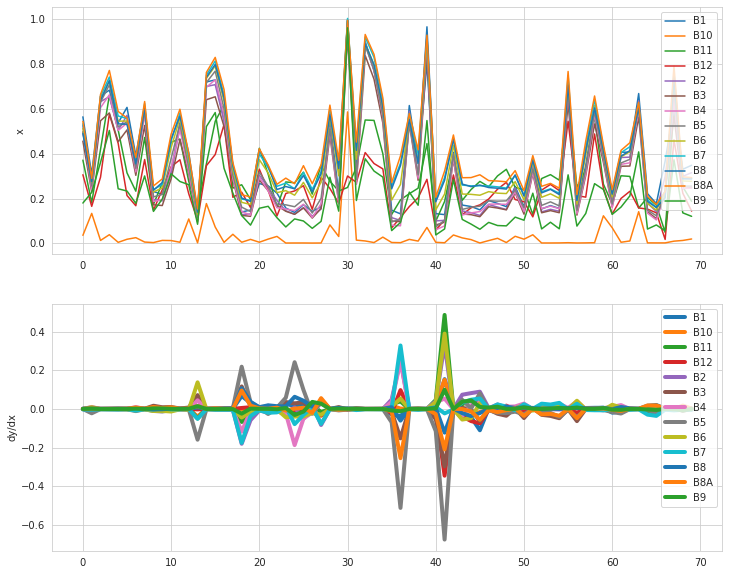

In [39]:
x_with_grad = torch.autograd.Variable(totorch(x).transpose(1,2), requires_grad=True)
logprobabilities, *_ = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy().T,linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

In [40]:
fname=os.path.join(csvdir, "transformer", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0].T,fname)
fname=os.path.join(csvdir,"transformer", str(meta), f"x.csv")
save_csv(x,fname)

writing /tmp/transformer/71460046/dydx.csv
writing /tmp/transformer/71460046/x.csv


In [75]:
from rnn import RNN
from models.multi_scale_resnet import MSResNet
from TempCNN import TempCNN

model = RNN(input_dim=13, nclasses=23, hidden_dims=16, num_rnn_layers=6, dropout=0.294243177060266, bidirectional=True, use_layernorm=True)
_ = model.load(RNN_WEIGHTS)

loading model from /tmp/notebookdata/backprop/rnn.pth


writing /tmp/rnn/71460046/dydx.csv
writing /tmp/rnn/71460046/x.csv


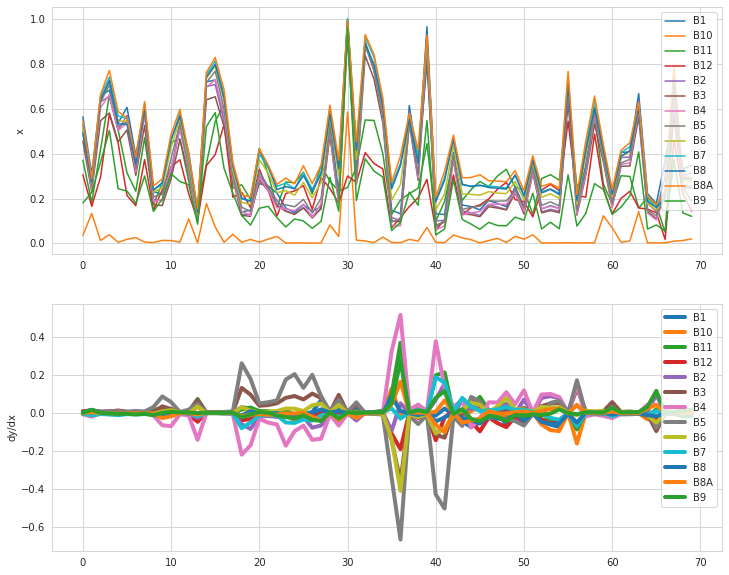

In [65]:
x_with_grad = torch.autograd.Variable(totorch(x).transpose(1,2), requires_grad=True)
logprobabilities, *_ = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy().T,linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "rnn", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0].T,fname)
fname=os.path.join(csvdir,"rnn", str(meta), f"x.csv")
save_csv(x,fname)

In [76]:
model = MSResNet(input_channel=13, layers=[1, 1, 1, 1], num_classes=23)
_ = model.load(MSRESNET_WEIGHTS)

loading model from /tmp/notebookdata/backprop/msresnet.pth


writing /tmp/msresnet/71460046/dydx.csv
writing /tmp/msresnet/71460046/x.csv


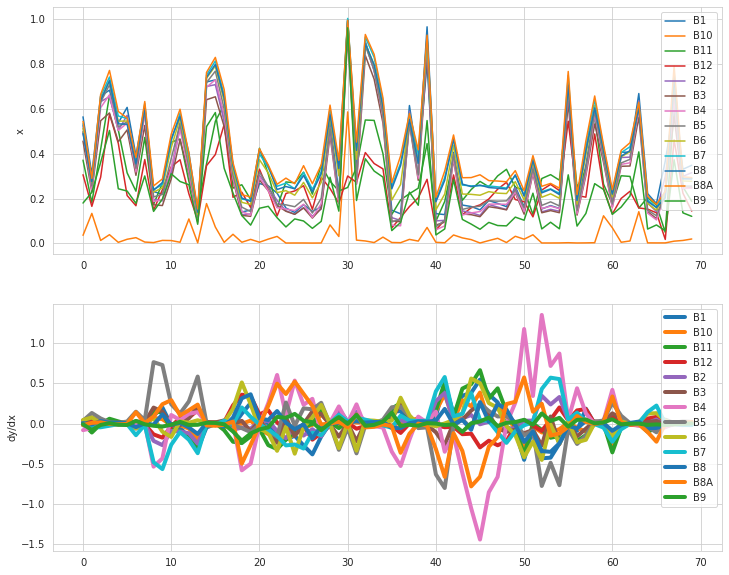

In [77]:
x_with_grad = torch.autograd.Variable(totorch(x).transpose(1,2), requires_grad=True)
logprobabilities,*_ = model.forward(x_with_grad)
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy().T)
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy().T,linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "msresnet", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0].T,fname)
fname=os.path.join(csvdir,"msresnet", str(meta), f"x.csv")
save_csv(x,fname)

loading model from /tmp/notebookdata/backprop/tempcnn.pth
writing /tmp/tempcnn/71460046/dydx.csv
writing /tmp/tempcnn/71460046/x.csv


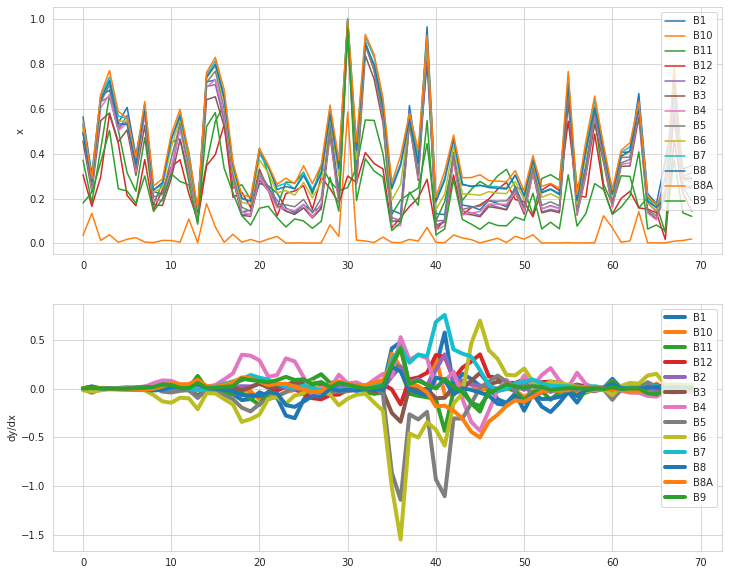

In [78]:
model = TempCNN(input_dim=13, nclasses=23, sequence_length=70)
_ = model.load(TEMPCNN_WEIGHTS)
model.eval()

x_with_grad = torch.autograd.Variable(totorch(x), requires_grad=True)
logprobabilities,*_ = model.forward(x_with_grad.transpose(1,2))
maxypred = logprobabilities.exp().max()
maxypred.backward()
dydx = x_with_grad.grad

fig, axs = plt.subplots(2, figsize=(12,10))
axs[0].plot(x_with_grad[0].detach().numpy())
axs[0].set_ylabel("x")
axs[0].legend(BANDS)
axs[1].plot(x_with_grad.grad[0].numpy(),linewidth=4)
axs[1].set_ylabel("dy/dx")
axs[1].legend(BANDS)

fname=os.path.join(csvdir, "tempcnn", str(meta), "dydx.csv")
save_csv(dydx.numpy()[0],fname)
fname=os.path.join(csvdir,"tempcnn", str(meta), f"x.csv")
save_csv(x,fname)